<a href="https://colab.research.google.com/github/konkuk-gaegul/2nd-Team-Project/blob/main/Feature_Set_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [ ]:
!pip install lightgbm
!pip install xgboost
!pip install eli5 shap catboost
!pip install optuna

In [ ]:
import tensorflow as tf

from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_validate

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets

# ML
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# ensemble(bagging)
from sklearn.ensemble import ( 
  BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor
)

#ensemble(boosting)
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

#stacking
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier, StackingRegressor

# 평가
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, classification_report

# 교차검증
from sklearn.model_selection import (
  KFold, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, train_test_split
)

# Feature Selection
from sklearn.feature_selection import RFE, RFECV

# 시각화(SVM은 회귀계수가 나오지 않습니다.)
import eli5
from eli5.sklearn import PermutationImportance
import shap

# 트리 시각화
import graphviz

# 인코딩
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

# feature_set_4
- 기존 고득점 세트였던 feature_set_2 참조
- CatBoost는 Categorical feature의 중요도가 높다고 판단
    - gender, car, reality 등 6개 Category 변수를 조합
        - 파생변수 'G_C_R' , 'I_O_E' , 'F_H' 생성
- Optuna Library를 이용하여 최적의 CatBoost HyperParameter를 찾아보자
    - 구글 코랩 환경에서 메모리 부족으로 셧다운
    - AWS GPU를 사용하여 모델링하였음

## 전처리 및 데이터 가공

### 전처리에 이용되는 함수

In [ ]:
# day를 year로 변경해주는 함수
def days_to_year(x):
    return (x*-1)/365

# 마이너스 변환
def minus(x):
    return x * -1

### 파생변수, 가중치, 전처리
- categorical
- numerical

In [ ]:
train_path = '/content/drive/MyDrive/data/credit/rawData/train.csv'
test_path = '/content/drive/MyDrive/data/credit/rawData/test.csv'

In [ ]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [ ]:
train.head(2)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0


In [ ]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
# ------------------------------------------------------------------- #
def categoric(df):

# 1. 의미없는 변수 제거 : index, FLAG_MOBIL, child_num
    df.drop(['index', 'FLAG_MOBIL', 'child_num'], axis=1, inplace = True)

# 2. 이상치 처리
    # 가족수 9명 이상, 6개 자료 삭제 및 인덱스 재설정 
    df = df[ ( df['family_size'] <= 7 ) ]
    df = df.reset_index(drop=True)

# 3. 결측치 처리
    # 첫 째, 결측치 & 근무일이 양수 & 연금수령자 인 경우 retiree(퇴직자)
    # 둘 째, 결측치 & 근무일이 음수인 경우 다양한 income_type 분포로 인해 No response처리
    df.loc[ (df.occyp_type.isna() == True) & (df.DAYS_EMPLOYED > 0) & 
           (df.income_type == 'Pensioner') , 'occyp_type' ] = 'retiree'
    df['DAYS_EMPLOYED'] = df[ 'DAYS_EMPLOYED' ].map(lambda x: 0 if x>0 else x)
    df.occyp_type.fillna('No response', inplace=True) 

# 4. 새로운 변수 ID열 생성 : 한 사람이 다수의 카드를 발급 받았을 경우
    df['ID'] = \
    df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)

# 5. gender+car+reality 변수 : 자산
    df['G_C_R'] = \
    df['gender'] + '_' + df['car'] + '_' + df['reality']

# 6. income_type+occyp_type+edu_type 변수 : 경제 활동
    df['I_O_E'] = \
    df['income_type'] + '_' + df['occyp_type'] + '_' + df['edu_type']

# 7. family_type+house_type : 가정 환경
    df['F_H'] = \
    df['family_type'] + '_' + df['house_type']

    return df
# ------------------------------------------------------------------- #

In [ ]:
train = categoric(train)
test  = categoric(test)

In [ ]:
train.head(2)

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,ID,G_C_R,I_O_E,F_H
0,F,N,N,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,0,0,0,No response,2.0,-6.0,1.0,202500.0_-13899_-4709_0_0_0_2.0_F_N_N_Commerci...,F_N_N,Commercial associate_No response_Higher education,Married_Municipal apartment
1,F,N,Y,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,0,0,1,Laborers,3.0,-5.0,1.0,247500.0_-11380_-1540_0_0_1_3.0_F_N_Y_Commerci...,F_N_Y,Commercial associate_Laborers_Secondary / seco...,Civil marriage_House / apartment


In [ ]:
# ------------------------------------------------------------------- #
def numeric(df):

# 1. 음수자료를 양수로 변환
    feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
    for feat in feats:
        df[feat] = np.abs(df[feat])

# 3. income_total 가중치 (numerical EDA 참조)
    df['income_weight']=df.income_total**2
    df['income_age']=df.income_total*df.DAYS_BIRTH
    df['income_emp']=df.income_total*df.DAYS_EMPLOYED
    df['income_total'] = df['income_total']/10000
    df['income_total_dev'] = (df['income_total'] - df['income_total'].mean())**2 # 편차제곱
    df['income_total_log'] = df['income_total'].apply(np.log1p)                  # 로그변환

# 4. DAYS_EMPLOYED 가중치
    df['DAYS_EMPLOYED_log'] = df['DAYS_EMPLOYED'].apply(np.log1p) # 로그 변환
    df['DAYS_EMPLOYED_before'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED'] # 로그 변환
    
# 5. type 변환
    df.income_total = df.income_total.astype(int)
    df.family_size = df.family_size.astype(int)
    df.begin_month = df.begin_month.astype(int)

# 6. 파생변수
    df['income_weight'] = 1/(df.income_weight)**3
    df['DAYS_BIRTH_cubic'] = df.DAYS_BIRTH**3
    df['DAYS_BIRTH_weight'] = 1/(df.DAYS_BIRTH)**2
    df['income_family'] = df.income_total / df.family_size
    return df
# ------------------------------------------------------------------- #

### 인코딩

In [ ]:
# ID 인코딩
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  30
Number of Categorical features:  0


In [ ]:
numerical_feats

['income_total',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'work_phone',
 'phone',
 'email',
 'family_size',
 'begin_month']

In [ ]:
categorical_feats

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type',
 'ID',
 'G_C_R',
 'I_O_E',
 'F_H']

In [ ]:
encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
test[categorical_feats] = encoder.transform(test[categorical_feats])

train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')

In [ ]:
categorical_feats

[]

In [ ]:
train = numeric(train)
test  = numeric(test)

### Clustering

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans_train = train.drop(['credit'], axis=1)
kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
train['cluster'] = kmeans.predict(kmeans_train)
test['cluster'] = kmeans.predict(test)

In [ ]:
train['cluster'].value_counts()

In [ ]:
sns.countplot(data=train, x='cluster', hue='credit')

### StandardScaling
- 이미 로그변환한 열은 제외한다.
- gender, car, reality 등 categorical feat은 제외
    - CatBoost의 parameter 중 하나인 cat_feature에는 int 또는 str만 입력 가능

In [ ]:
from sklearn.preprocessing import StandardScaler
import multiprocessing

# Optuna
- Best HyperParameter 튜닝
    - 구글 코랩 환경은 메모리 부족
    - AWS 쥬피터 노트북으로 실행
        - GPU는 상당히 빨리 처리한다...

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import glob
import pandas as pd
import numpy as np

from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder
import random

import optuna
from optuna.samplers import TPESampler

In [ ]:
#Optuna용 Train셋
X = train.drop(['credit'],axis=1)
y = train['credit']
X_test = test.copy()

In [ ]:
def objective(trial):
  param = {
      "random_state":42,
      'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
      'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
      "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
      "max_depth":trial.suggest_int("max_depth", 4, 16),
      'random_strength' :trial.suggest_int('random_strength', 0, 100),
      "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
      "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
      "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
      "max_bin": trial.suggest_int("max_bin", 200, 500),
      'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
  }

  X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.2)
  
  cat_features =['gender','car','reality','income_type', 'edu_type', 'family_type',
                 'house_type', 'occyp_type', 'ID', 'F_H']
  cat = CatBoostClassifier(**param)
  cat.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_valid,y_valid)],
          early_stopping_rounds=35,cat_features=cat_features,
          verbose=100)
  cat_pred = cat.predict_proba(X_valid)
  log_score = log_loss(y_valid, cat_pred)

  return log_score

In [ ]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'minimize',
    sampler = sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:",study.best_value)
print("Best trial",study.best_trial.params)

[I 2022-03-03 16:30:08,048] A new study created in memory with name: cat_parameter_opt


0:	learn: 1.0828775	test: 1.0828775	test1: 1.0830258	best: 1.0830258 (0)	total: 82.5ms	remaining: 10m 26s
100:	learn: 0.8815088	test: 0.8815088	test1: 0.8873741	best: 0.8873741 (100)	total: 2.29s	remaining: 2m 50s


[I 2022-03-03 16:30:11,830] Trial 0 finished with value: 0.8873625541902477 and parameters: {'learning_rate': 0.03574712922600244, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'colsample_bylevel': 0.49359671220172163, 'l2_leaf_reg': 1.7519275289243016e-06, 'min_child_samples': 88, 'max_bin': 380, 'od_type': 'IncToDec'}. Best is trial 0 with value: 0.8873625541902477.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8873625542
bestIteration = 108

Shrink model to first 109 iterations.
0:	learn: 0.9929890	test: 0.9929890	test1: 0.9946005	best: 0.9946005 (0)	total: 137ms	remaining: 6m 39s
100:	learn: 0.7011239	test: 0.7116694	test1: 0.7869701	best: 0.7869701 (100)	total: 12.9s	remaining: 5m 59s
200:	learn: 0.6216065	test: 0.6395257	test1: 0.7690058	best: 0.7690058 (200)	total: 25.6s	remaining: 5m 44s
300:	learn: 0.5635082	test: 0.5884329	test1: 0.7598308	best: 0.7598308 (300)	total: 38.5s	remaining: 5m 33s


[I 2022-03-03 16:31:00,777] Trial 1 finished with value: 0.7563750625454062 and parameters: {'learning_rate': 0.2708160864249968, 'bagging_temperature': 21.368329072358772, 'n_estimators': 2911, 'max_depth': 6, 'random_strength': 18, 'colsample_bylevel': 0.5825453457757226, 'l2_leaf_reg': 1.5747445384650815e-05, 'min_child_samples': 46, 'max_bin': 287, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.7563750625454062.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.7563750625
bestIteration = 343

Shrink model to first 344 iterations.
0:	learn: 1.0865207	test: 1.0865820	test1: 1.0863963	best: 1.0863963 (0)	total: 643ms	remaining: 54m 40s
100:	learn: 0.8096701	test: 0.7307479	test1: 0.7908628	best: 0.7908628 (100)	total: 1m 36s	remaining: 1h 19m 50s
200:	learn: 0.7607791	test: 0.6315574	test1: 0.7373602	best: 0.7373602 (200)	total: 3m 4s	remaining: 1h 14m 55s
300:	learn: 0.7369826	test: 0.5817997	test1: 0.7139311	best: 0.7139311 (300)	total: 4m	remaining: 1h 4m 4s
400:	learn: 0.7130936	test: 0.5360607	test1: 0.6954358	best: 0.6954358 (400)	total: 5m 54s	remaining: 1h 9m 13s
500:	learn: 0.5846472	test: 0.4804680	test1: 0.6754460	best: 0.6754031 (499)	total: 10m 42s	remaining: 1h 38m 21s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6735830503
bestIteration = 543

Shrink model to first 544 iterations.


[I 2022-03-03 16:47:06,947] Trial 2 finished with value: 0.6735830502821478 and parameters: {'learning_rate': 0.027010527749605478, 'bagging_temperature': 0.2920433847181412, 'n_estimators': 5105, 'max_depth': 14, 'random_strength': 20, 'colsample_bylevel': 0.708540663048167, 'l2_leaf_reg': 1.7776512920172654e-05, 'min_child_samples': 9, 'max_bin': 382, 'od_type': 'IncToDec'}. Best is trial 2 with value: 0.6735830502821478.


0:	learn: 1.0004786	test: 1.0004786	test1: 1.0008649	best: 1.0008649 (0)	total: 21ms	remaining: 2m 53s


[I 2022-03-03 16:47:08,684] Trial 3 finished with value: 0.8836591024581331 and parameters: {'learning_rate': 0.2521267904777921, 'bagging_temperature': 72.86653737491046, 'n_estimators': 8276, 'max_depth': 7, 'random_strength': 9, 'colsample_bylevel': 0.8105398159072941, 'l2_leaf_reg': 1.3210173287250643e-05, 'min_child_samples': 16, 'max_bin': 349, 'od_type': 'Iter'}. Best is trial 2 with value: 0.6735830502821478.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8836591025
bestIteration = 20

Shrink model to first 21 iterations.
0:	learn: 1.0877152	test: 1.0878579	test1: 1.0878720	best: 1.0878720 (0)	total: 301ms	remaining: 19m 6s
100:	learn: 0.7720632	test: 0.6972826	test1: 0.7685879	best: 0.7685879 (100)	total: 24.5s	remaining: 15m
200:	learn: 0.7155331	test: 0.5972533	test1: 0.7209561	best: 0.7209561 (200)	total: 49.3s	remaining: 14m 43s
300:	learn: 0.6780834	test: 0.5567816	test1: 0.7055827	best: 0.7055827 (300)	total: 1m 18s	remaining: 15m 18s
400:	learn: 0.6372230	test: 0.5257345	test1: 0.6951886	best: 0.6951886 (400)	total: 1m 49s	remaining: 15m 30s
500:	learn: 0.5761083	test: 0.4995616	test1: 0.6876373	best: 0.6876373 (500)	total: 2m 23s	remaining: 15m 46s
600:	learn: 0.5173167	test: 0.4764607	test1: 0.6834759	best: 0.6834233 (599)	total: 2m 56s	remaining: 15m 42s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6834232539
bestIteration = 599

Shrink

[I 2022-03-03 16:50:17,198] Trial 4 finished with value: 0.6834232539376278 and parameters: {'learning_rate': 0.024112898115291985, 'bagging_temperature': 4.467752817973908, 'n_estimators': 3805, 'max_depth': 10, 'random_strength': 55, 'colsample_bylevel': 0.5109126733153162, 'l2_leaf_reg': 2.9087842986659113e-05, 'min_child_samples': 79, 'max_bin': 482, 'od_type': 'IncToDec'}. Best is trial 2 with value: 0.6735830502821478.


0:	learn: 1.0074444	test: 1.0074493	test1: 1.0082218	best: 1.0082218 (0)	total: 131ms	remaining: 6m 3s
100:	learn: 0.7109815	test: 0.4815845	test1: 0.6780513	best: 0.6780186 (99)	total: 7.03s	remaining: 3m 5s


[I 2022-03-03 16:50:29,117] Trial 5 finished with value: 0.677488080938512 and parameters: {'learning_rate': 0.22999586428143728, 'bagging_temperature': 0.022592797420156956, 'n_estimators': 2764, 'max_depth': 4, 'random_strength': 32, 'colsample_bylevel': 0.6332063738136893, 'l2_leaf_reg': 8.147757462899138e-06, 'min_child_samples': 84, 'max_bin': 307, 'od_type': 'Iter'}. Best is trial 2 with value: 0.6735830502821478.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6774880809
bestIteration = 115

Shrink model to first 116 iterations.
0:	learn: 1.0863772	test: 1.0883014	test1: 1.0907096	best: 1.0907096 (0)	total: 11.1s	remaining: 5h 7m 38s
100:	learn: 0.5176032	test: 0.5593905	test1: 0.7932242	best: 0.7932242 (100)	total: 20m 4s	remaining: 5h 12m 2s
200:	learn: 0.3293935	test: 0.3879037	test1: 0.7750893	best: 0.7733051 (165)	total: 34m 29s	remaining: 4h 12m 12s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.7733051342
bestIteration = 165

Shrink model to first 166 iterations.


[I 2022-03-03 17:25:00,676] Trial 6 finished with value: 0.7733051342289939 and parameters: {'learning_rate': 0.016149614799999188, 'bagging_temperature': 16.172900811143155, 'n_estimators': 1671, 'max_depth': 16, 'random_strength': 77, 'colsample_bylevel': 0.5192294089205034, 'l2_leaf_reg': 1.7560829253683595e-07, 'min_child_samples': 83, 'max_bin': 412, 'od_type': 'Iter'}. Best is trial 2 with value: 0.6735830502821478.


0:	learn: 1.0929256	test: 1.0929256	test1: 1.0928710	best: 1.0928710 (0)	total: 16.5ms	remaining: 33.7s
100:	learn: 0.8844129	test: 0.8677947	test1: 0.8819082	best: 0.8819082 (100)	total: 38.9s	remaining: 12m 42s
200:	learn: 0.8361761	test: 0.7762750	test1: 0.8274152	best: 0.8274152 (200)	total: 1m 30s	remaining: 14m
300:	learn: 0.8039787	test: 0.7030853	test1: 0.7909375	best: 0.7909375 (300)	total: 2m 46s	remaining: 16m 11s
400:	learn: 0.7801718	test: 0.6431539	test1: 0.7646889	best: 0.7646889 (400)	total: 4m 10s	remaining: 17m 10s
500:	learn: 0.7670629	test: 0.6168991	test1: 0.7528197	best: 0.7528174 (497)	total: 5m 9s	remaining: 15m 56s
600:	learn: 0.7562842	test: 0.5942632	test1: 0.7438316	best: 0.7438316 (600)	total: 6m 30s	remaining: 15m 39s
700:	learn: 0.7477095	test: 0.5746262	test1: 0.7362578	best: 0.7362578 (700)	total: 7m 16s	remaining: 13m 56s
800:	learn: 0.7372998	test: 0.5581224	test1: 0.7288648	best: 0.7288648 (800)	total: 8m 23s	remaining: 13m 1s
900:	learn: 0.7209885	t

[I 2022-03-03 17:48:02,592] Trial 7 finished with value: 0.6846144068718785 and parameters: {'learning_rate': 0.012863908101989912, 'bagging_temperature': 0.27155819552829413, 'n_estimators': 2042, 'max_depth': 15, 'random_strength': 62, 'colsample_bylevel': 0.5985388149115896, 'l2_leaf_reg': 1.9161149250778487e-06, 'min_child_samples': 34, 'max_bin': 297, 'od_type': 'IncToDec'}. Best is trial 2 with value: 0.6735830502821478.


0:	learn: 1.0167233	test: 1.0167285	test1: 1.0170722	best: 1.0170722 (0)	total: 31.8ms	remaining: 1m 5s
100:	learn: 0.3006564	test: 0.4153692	test1: 0.7344807	best: 0.6892745 (69)	total: 1m 1s	remaining: 19m 58s


[I 2022-03-03 17:49:08,773] Trial 8 finished with value: 0.6892744801094646 and parameters: {'learning_rate': 0.20441878352493792, 'bagging_temperature': 0.7742116473996251, 'n_estimators': 2076, 'max_depth': 13, 'random_strength': 76, 'colsample_bylevel': 0.7367663185416977, 'l2_leaf_reg': 2.3131305726837285e-05, 'min_child_samples': 52, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 2 with value: 0.6735830502821478.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6892744801
bestIteration = 69

Shrink model to first 70 iterations.
0:	learn: 1.0922062	test: 1.0922057	test1: 1.0922210	best: 1.0922210 (0)	total: 37.1ms	remaining: 4m 9s
100:	learn: 0.8869543	test: 0.8839723	test1: 0.8889405	best: 0.8889405 (100)	total: 6.22s	remaining: 6m 48s
200:	learn: 0.8440065	test: 0.7989567	test1: 0.8358204	best: 0.8358204 (200)	total: 12.8s	remaining: 6m 56s
300:	learn: 0.8181507	test: 0.7278864	test1: 0.7984220	best: 0.7984220 (300)	total: 23.6s	remaining: 8m 22s
400:	learn: 0.8040011	test: 0.6831164	test1: 0.7779502	best: 0.7779502 (400)	total: 37s	remaining: 9m 43s
500:	learn: 0.7898408	test: 0.6460959	test1: 0.7601807	best: 0.7601807 (499)	total: 52.2s	remaining: 10m 48s
600:	learn: 0.7788907	test: 0.6206618	test1: 0.7475205	best: 0.7475205 (600)	total: 1m 6s	remaining: 11m 16s
700:	learn: 0.7687870	test: 0.5978980	test1: 0.7364983	best: 0.7364983 (700)	total: 1m 21s	remaining: 11m 40s
80

[I 2022-03-03 17:52:01,020] Trial 9 finished with value: 0.6717837325495211 and parameters: {'learning_rate': 0.01443340240633889, 'bagging_temperature': 0.0133572404119741, 'n_estimators': 6728, 'max_depth': 8, 'random_strength': 51, 'colsample_bylevel': 0.9445398843556558, 'l2_leaf_reg': 7.486273952174759e-06, 'min_child_samples': 44, 'max_bin': 427, 'od_type': 'IncToDec'}. Best is trial 9 with value: 0.6717837325495211.


Best Score: 0.6717837325495211
Best trial {'learning_rate': 0.01443340240633889, 'bagging_temperature': 0.0133572404119741, 'n_estimators': 6728, 'max_depth': 8, 'random_strength': 51, 'colsample_bylevel': 0.9445398843556558, 'l2_leaf_reg': 7.486273952174759e-06, 'min_child_samples': 44, 'max_bin': 427, 'od_type': 'IncToDec'}


In [ ]:
Best_trial = {'learning_rate': 0.01443340240633889,
 'bagging_temperature': 0.0133572404119741,
 'n_estimators': 6728,
 'max_depth': 8,
 'random_strength': 51,
 'colsample_bylevel': 0.9445398843556558,
 'l2_leaf_reg': 7.486273952174759e-06,
 'min_child_samples': 44,
 'max_bin': 427,
 'od_type': 'IncToDec'}

In [ ]:
study.best_trial.params

{'learning_rate': 0.01443340240633889,
 'bagging_temperature': 0.0133572404119741,
 'n_estimators': 6728,
 'max_depth': 8,
 'random_strength': 51,
 'colsample_bylevel': 0.9445398843556558,
 'l2_leaf_reg': 7.486273952174759e-06,
 'min_child_samples': 44,
 'max_bin': 427,
 'od_type': 'IncToDec'}

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = []
for train_idx, valid_idx in skf.split(train, train['credit']):
  folds.append((train_idx,valid_idx))

In [ ]:
folds

[(array([    0,     1,     2, ..., 26447, 26448, 26450]),
  array([    4,    19,    21, ..., 26440, 26446, 26449])),
 (array([    3,     4,     7, ..., 26448, 26449, 26450]),
  array([    0,     1,     2, ..., 26429, 26441, 26444])),
 (array([    0,     1,     2, ..., 26447, 26448, 26449]),
  array([    8,    10,    15, ..., 26432, 26442, 26450])),
 (array([    0,     1,     2, ..., 26448, 26449, 26450]),
  array([    7,    12,    18, ..., 26434, 26436, 26447])),
 (array([    0,     1,     2, ..., 26447, 26449, 26450]),
  array([    3,     9,    14, ..., 26443, 26445, 26448]))]

In [ ]:
train.head()

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,...,income_age,income_emp,income_total_dev,income_total_log,DAYS_EMPLOYED_log,DAYS_EMPLOYED_before,DAYS_BIRTH_cubic,DAYS_BIRTH_weight,income_family,cluster
0,1,1,1,0.161391,1,1,1,1,-0.490076,1.059065,...,-0.081866,0.926979,-0.228231,0.398667,0.767044,-0.939097,-0.619941,0.101212,0.013245,12
1,1,1,2,0.552464,1,2,2,2,-1.089581,-0.277867,...,-0.080752,-0.091955,-0.151951,0.824300,0.386561,-0.805515,-0.955480,1.020725,-0.261341,11
2,2,2,2,2.605599,2,1,1,2,0.744635,0.943049,...,3.133071,2.781294,1.318284,2.110005,0.746556,0.183614,0.562514,-0.777220,1.729407,10
3,1,1,2,0.161391,1,2,1,2,-0.207101,-0.044990,...,0.052181,-0.016339,-0.228231,0.398667,0.490826,-0.156919,-0.412263,-0.181911,0.013245,5
4,1,2,2,-0.327450,3,1,1,2,-0.219239,-0.039505,...,-0.330294,-0.180267,-0.213443,-0.128636,0.492935,-0.170072,-0.421879,-0.171128,-0.329988,5


In [ ]:
# numerical_feats.remove('DAYS_EMPLOYED_log')
# numerical_feats.remove('income_total_log')
category = ['gender','car','reality','income_type','edu_type',
            'family_type','house_type','occyp_type','ID',
            'G_C_R','I_O_E','F_H']
for i in category:
    numerical_feats.remove(i)
numerical_feats

['income_total',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'work_phone',
 'phone',
 'email',
 'family_size',
 'begin_month',
 'income_weight',
 'income_age',
 'income_emp',
 'income_total_dev',
 'income_total_log',
 'DAYS_EMPLOYED_log',
 'DAYS_EMPLOYED_before',
 'DAYS_BIRTH_cubic',
 'DAYS_BIRTH_weight',
 'income_family']

In [ ]:
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

# 모델링-1 (CatBoost)
- Optuna 결과 적용

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os
import random
from optuna.samplers import TPESampler
import multiprocessing
import catboost as cat
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pickle
from sklearn.utils import resample
from catboost import Pool
import sklearn.metrics

In [ ]:
# n_fold를 돌려보고 좋은 수치를 선택

n_est = 2000
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [ ]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]

for train_idx, valid_idx in skfold.split(X, y):
    folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['gender','car','reality','income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type',
            'ID','G_C_R','F_H']

for fold in range(n_fold):
    print(f'\n----------------- Fold {fold} -----------------\n')
  
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)
    model_cat = CatBoostClassifier(**study.best_params)
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
    
    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / n_fold
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')


----------------- Fold 0 -----------------

0:	learn: 1.0921875	test: 1.0922084	best: 1.0922084 (0)	total: 140ms	remaining: 15m 40s
100:	learn: 0.8799558	test: 0.8738823	best: 0.8738823 (100)	total: 17s	remaining: 18m 37s
200:	learn: 0.8411028	test: 0.8220687	best: 0.8220687 (200)	total: 32.9s	remaining: 17m 48s
300:	learn: 0.8216370	test: 0.7937423	best: 0.7937423 (300)	total: 46.7s	remaining: 16m 36s
400:	learn: 0.8039316	test: 0.7682281	best: 0.7682281 (400)	total: 1m 2s	remaining: 16m 25s
500:	learn: 0.7893795	test: 0.7490824	best: 0.7490824 (500)	total: 1m 19s	remaining: 16m 22s
600:	learn: 0.7778911	test: 0.7329813	best: 0.7329813 (600)	total: 1m 34s	remaining: 16m 7s
700:	learn: 0.7673642	test: 0.7192914	best: 0.7192914 (700)	total: 1m 54s	remaining: 16m 23s
800:	learn: 0.7439370	test: 0.6906759	best: 0.6906759 (800)	total: 2m 12s	remaining: 16m 19s
900:	learn: 0.7200614	test: 0.6620279	best: 0.6620279 (900)	total: 2m 33s	remaining: 16m 31s
1000:	learn: 0.7033791	test: 0.645840

In [ ]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

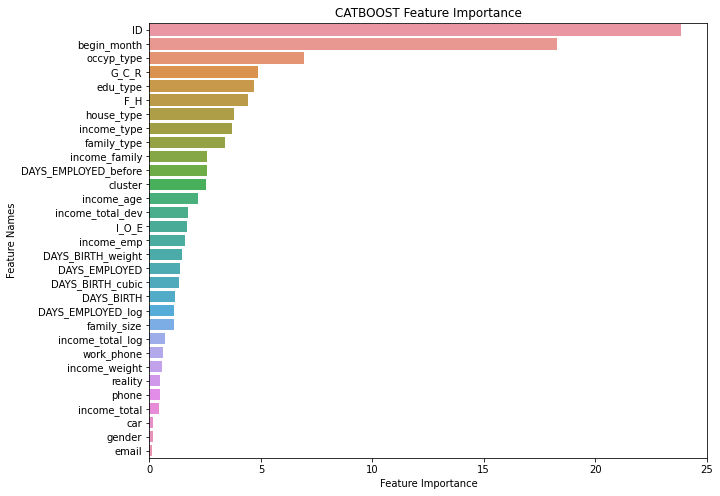

In [ ]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

In [ ]:
sub = pd.read_csv('/home/lab07/data/sample_submission.csv')

In [ ]:
sub.iloc[:, 1:] = cat_pred_test

In [ ]:
sub.to_csv('/home/lab07/data/submission_feature_catboost_optuna_nfold_15.csv', index=False)

# 모델링-1 후기
- 점수 0.66659, 12등
- 오랜 시간(3시간)이 소요되지만, Optuna의 효과는 최대로 발휘했다.
- 역시 CatBoost는 Categorical 변수가 중요해보인다.
- 다음 Machine Learging 경진대회에서는 다양한 알고리즘과 그에 맞는 feature engineering을 할 것이다.